In [160]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np

In [161]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [162]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [163]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

In [164]:

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [165]:
img_transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [166]:
mask_transform = transforms.Compose([
    transforms.Resize((128,128)),
    ])


In [167]:
mask_transform_bce = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.01).float())  # Lower threshold
])

In [168]:
train_dataset=datasets.OxfordIIITPet(root='data/',
                                     split='trainval',
                                     target_types="segmentation",
                                     download=True,
                                     transform=img_transform,
                                     target_transform=mask_transform_bce)

In [169]:
test_dataset=datasets.OxfordIIITPet(root='data/',
                                    split='test',
                                    target_types='segmentation',
                                    download=True,
                                    transform=img_transform,
                                    target_transform=mask_transform_bce)

In [170]:
train_loader=DataLoader(train_dataset,32,True)
test_loader=DataLoader(test_dataset,32,True)

In [171]:
img, mask = next(iter(train_loader))

print("Image:", img.min().item(), img.max().item())
print("Mask:", mask.min().item(), mask.max().item(), mask.unique())
#mask must be 1 or 2 or 4

Image: -2.1179039478302 2.640000104904175
Mask: 0.0 1.0 tensor([0., 1.])


In [172]:
img.shape

torch.Size([32, 3, 128, 128])

In [ ]:
img.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.2739873].


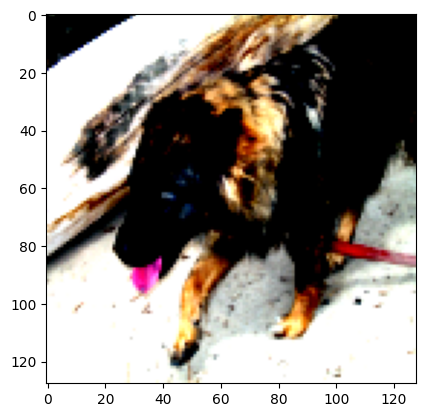

In [173]:
img=img[0]
img=img.permute(1,2,0)
plt.imshow(img)

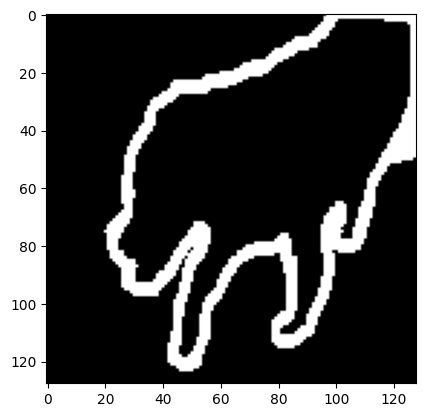

In [174]:
plt.imshow(mask[0][0],cmap='gray')

In [175]:
train_dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: data/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Target transform: Compose(
                      Resize(size=(128, 128), interpolation=nearest, max_size=None, antialias=True)
                      ToTensor()
                      Lambda()
                  )

In [176]:
test_dataset[0][1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


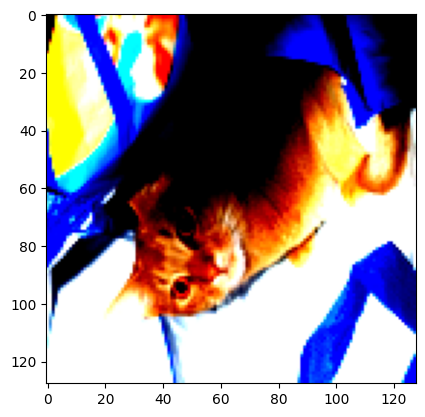

In [177]:
mask_tensor=train_dataset[0][0].squeeze()
mask_tensor=mask_tensor.permute(2,1,0)
plt.imshow(mask_tensor)

In [178]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [179]:
model=UNet(3,1).to(device)

In [180]:
lr=3e-4

In [181]:
optimizer=optim.AdamW(model.parameters(),lr=lr)

In [182]:
criterion = nn.BCEWithLogitsLoss()

In [183]:
writer=SummaryWriter(f"runs/UNET/OXFORDIIITPet")

In [184]:
#visualizing if everything is proper

dataiter = iter(train_loader)
images, masks = next(dataiter)
masks = masks   # [B, 1, H, W], convert to float
img_grid = torchvision.utils.make_grid(images)
mask_grid = torchvision.utils.make_grid(masks)
writer.add_image('train/images', img_grid)
writer.add_image('train/masks', mask_grid)

In [185]:
writer.add_graph(model, images.float().to(device))

In [186]:
step=0

In [193]:
for epochs in range(20):
    model.train()
    train_running_loss=0
    train_loader_tqdm=tqdm(train_loader,desc=f"Training Epoch {epochs}",leave=False)
    for idx,img_mask in enumerate(train_loader_tqdm):
        img=img_mask[0].float().to(device)
        mask=img_mask[1].float().to(device)
        y_pred=model(img)
        loss=criterion(y_pred,mask)
        train_running_loss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}")#when this line runs the bar is updated 
    train_loss=train_running_loss/len(train_loader)

    writer.add_scalar("Loss/train",train_loss,epochs)
    print(f"Epoch:{epochs}\nTrain Loss{train_loss}")

    model.eval()
    val_running_loss=0
    with torch.no_grad():
        test_loader_tqdm=tqdm(test_loader,desc=f"Validation Epoch {epochs}",leave=False)
        for idx,img_mask in enumerate(test_loader_tqdm):
            img=img_mask[0].float().to(device)
            mask=img_mask[1].float().to(device)
            y_pred=model(img)
            loss=criterion(y_pred,mask)
            val_running_loss+=loss.item()#you are adding the value inside loss and then later averaging
            test_loader_tqdm.set_postfix(loss=f"{loss.item():.4f}")
            if idx%10==0:
                pred_mask = torch.sigmoid(y_pred) > 0.5   # threshold

                img_grid=torchvision.utils.make_grid(img)
                mask_grid=torchvision.utils.make_grid(mask)
                pred_grid=torchvision.utils.make_grid(pred_mask)

                writer.add_image(f"Validation/Images",img_grid,global_step=step)
                writer.add_image(f"Validation/Mask",mask_grid,global_step=step)
                writer.add_image(f"Validation/Prediction",pred_grid,global_step=step)
                step+=1
            if idx==31:
                break

        val_loss=val_running_loss/(idx+1)
        writer.add_scalar('Loss/validation',val_loss,epochs)
        print(f"Validation Loss:{val_loss}")
writer.close()

Epoch:0
Train Loss0.2878610459358796


Validation Loss:0.2938398262485862


Epoch:1
Train Loss0.26952745875586637


Validation Loss:0.2655633292160928


Epoch:2
Train Loss0.25552499981030175


Validation Loss:0.24928358709439635


Epoch:3
Train Loss0.2386317903580873


Validation Loss:0.22766031371429563


Epoch:4
Train Loss0.2230716715688291


Validation Loss:0.21944968542084098


Epoch:5
Train Loss0.21121613564698594


Validation Loss:0.21142176585271955


Epoch:6
Train Loss0.20245086913523466


Validation Loss:0.20368445105850697


Epoch:7
Train Loss0.19434625726679097


Validation Loss:0.20508762588724494


Epoch:8
Train Loss0.18658494262591652


Validation Loss:0.19493722962215543


Epoch:9
Train Loss0.18085696334424226


Validation Loss:0.19251689733937383


Epoch:10
Train Loss0.1736434923565906


Validation Loss:0.19085189932957292


Epoch:11
Train Loss0.1677013117334117


Validation Loss:0.19372823182493448


Epoch:12
Train Loss0.1607838731745015


Validation Loss:0.18896301090717316


Epoch:13
Train Loss0.1532982473788054


Validation Loss:0.18632028251886368


Epoch:14
Train Loss0.14580727673095206


Validation Loss:0.19164364458993077


Epoch:15
Train Loss0.14010694765526316


Validation Loss:0.19828705536201596


Epoch:16
Train Loss0.13425736718851586


Validation Loss:0.20793941523879766


Epoch:17
Train Loss0.12650725634201712


Validation Loss:0.2051011035218835


Epoch:18
Train Loss0.12289709707965021


Validation Loss:0.20411705505102873


Epoch:19
Train Loss0.11588136929532757


Validation Loss:0.2277199886739254


In [188]:
print(mask.min().item(), mask.max().item(), mask.unique())


0.0 1.0 tensor([0., 1.], device='cuda:0')


In [189]:
print(mask.mean().item())


0.1283511221408844


In [190]:
img_mask=next(iter(train_loader))
mask=img_mask[0]
print(mask.min().item(), mask.max().item())

-2.1179039478302 2.640000104904175


In [191]:
mask

tensor([[[[ 1.4269,  1.6153,  1.1872,  ..., -1.7583, -1.6555, -1.5357],
          [ 0.8961,  1.7009,  1.3413,  ..., -1.7754, -1.6555, -1.5699],
          [ 0.8789,  1.7009,  1.5810,  ..., -1.7412, -1.6727, -1.5870],
          ...,
          [-0.0629,  0.1426,  0.1083,  ...,  0.2624,  0.2111,  0.2796],
          [ 0.0398,  0.2453,  0.1597,  ...,  0.3481,  0.2453,  0.2453],
          [ 0.0912,  0.1083,  0.2453,  ...,  0.2282,  0.2796,  0.2796]],

         [[ 1.5007,  1.9734,  1.5357,  ..., -1.8081, -1.7731, -1.7031],
          [ 0.6604,  1.9209,  1.6933,  ..., -1.7906, -1.7556, -1.7206],
          [ 0.7304,  2.0084,  1.9384,  ..., -1.8081, -1.7731, -1.7381],
          ...,
          [ 0.2927,  0.4853,  0.4853,  ...,  0.6779,  0.6078,  0.6604],
          [ 0.4153,  0.5553,  0.4853,  ...,  0.7304,  0.6429,  0.6429],
          [ 0.5378,  0.4678,  0.6078,  ...,  0.6429,  0.6954,  0.6954]],

         [[ 1.8034,  2.2391,  1.7860,  ..., -1.5779, -1.5256, -1.4733],
          [ 0.9842,  2.1868,  

In [192]:
img_mask[0].min().item(),img_mask

(-2.1179039478302,
 [tensor([[[[ 1.4269,  1.6153,  1.1872,  ..., -1.7583, -1.6555, -1.5357],
            [ 0.8961,  1.7009,  1.3413,  ..., -1.7754, -1.6555, -1.5699],
            [ 0.8789,  1.7009,  1.5810,  ..., -1.7412, -1.6727, -1.5870],
            ...,
            [-0.0629,  0.1426,  0.1083,  ...,  0.2624,  0.2111,  0.2796],
            [ 0.0398,  0.2453,  0.1597,  ...,  0.3481,  0.2453,  0.2453],
            [ 0.0912,  0.1083,  0.2453,  ...,  0.2282,  0.2796,  0.2796]],
  
           [[ 1.5007,  1.9734,  1.5357,  ..., -1.8081, -1.7731, -1.7031],
            [ 0.6604,  1.9209,  1.6933,  ..., -1.7906, -1.7556, -1.7206],
            [ 0.7304,  2.0084,  1.9384,  ..., -1.8081, -1.7731, -1.7381],
            ...,
            [ 0.2927,  0.4853,  0.4853,  ...,  0.6779,  0.6078,  0.6604],
            [ 0.4153,  0.5553,  0.4853,  ...,  0.7304,  0.6429,  0.6429],
            [ 0.5378,  0.4678,  0.6078,  ...,  0.6429,  0.6954,  0.6954]],
  
           [[ 1.8034,  2.2391,  1.7860,  ..., -1.57

In [195]:
#overfitting is happening das it

CHECKPOINT_PATH='Models/unet-oxford-pet.pth'

torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, CHECKPOINT_PATH)